<a href="https://colab.research.google.com/github/Rajeeb17/CVPR/blob/main/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

assignment1

Dataset found at: animal_data/animal_dataset
Images loaded: (300, 1024) Labels: 300 Classes: ['cat', 'dog', 'panda']
K=1  |  L1=0.3667  L2=0.3500
K=3  |  L1=0.4233  L2=0.3800
K=5  |  L1=0.4567  L2=0.3833
K=7  |  L1=0.4133  L2=0.4100
K=9  |  L1=0.4167  L2=0.4133
K=11  |  L1=0.4133  L2=0.3967


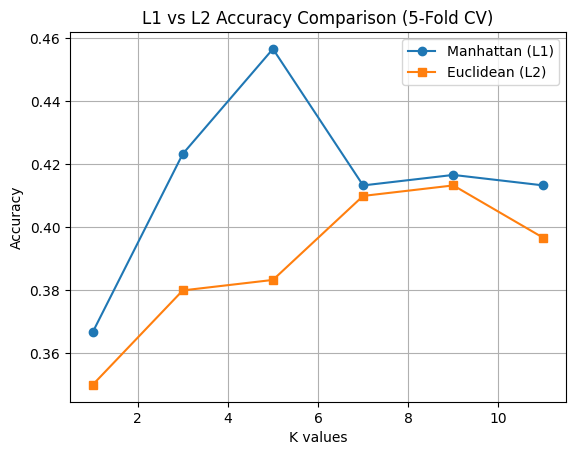


Best K (L1) = 5  Accuracy= 0.45666666666666667
Best K (L2) = 9  Accuracy= 0.4133333333333334

 Manhattan (L1) works better on this dataset!


In [6]:
import zipfile, os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from collections import Counter


zip_file = "/animal_dataset.zip"
extract_to = "animal_data"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_file, "r") as z:
    z.extractall(extract_to)

base_dir = extract_to + "/animal_dataset"
print("Dataset found at:", base_dir)



def load_images(folder, size=(32,32)):
    X=[]; y=[]
    class_names = sorted(os.listdir(folder))
    label = {cls:i for i,cls in enumerate(class_names)}

    for cls in class_names:
        path = os.path.join(folder, cls)
        for img_file in os.listdir(path):
            img = Image.open(os.path.join(path,img_file)).convert("L")
            img = img.resize(size)
            X.append(np.array(img).flatten()/255.0)
            y.append(label[cls])

    return np.array(X), np.array(y), class_names


X,y,class_names = load_images(base_dir)
print("Images loaded:",X.shape,"Labels:",len(y),"Classes:",class_names)


def knn_predict(X_train,y_train,X_test,k,dist):
    y_pred=[]
    for x in X_test:

        if dist=="l1":
            d=np.sum(np.abs(X_train-x),axis=1)
        else:
            d=np.sqrt(np.sum((X_train-x)**2,axis=1))

        idx=np.argsort(d)[:k]
        lab=Counter(y_train[idx]).most_common(1)[0][0]
        y_pred.append(lab)

    return np.array(y_pred)


K_values=[1,3,5,7,9,11]
acc_l1=[]; acc_l2=[]

kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

for k in K_values:
    fold_l1=[]; fold_l2=[]

    for tr,va in kf.split(X,y):
        Xtr,Xv=X[tr],X[va]
        Ytr,Yv=y[tr],y[va]

        p1=knn_predict(Xtr,Ytr,Xv,k,"l1")
        p2=knn_predict(Xtr,Ytr,Xv,k,"l2")

        fold_l1.append(accuracy_score(Yv,p1))
        fold_l2.append(accuracy_score(Yv,p2))

    acc_l1.append(np.mean(fold_l1))
    acc_l2.append(np.mean(fold_l2))
    print(f"K={k}  |  L1={acc_l1[-1]:.4f}  L2={acc_l2[-1]:.4f}")


plt.plot(K_values,acc_l1,'o-',label="Manhattan (L1)")
plt.plot(K_values,acc_l2,'s-',label="Euclidean (L2)")
plt.xlabel("K values"); plt.ylabel("Accuracy")
plt.title("L1 vs L2 Accuracy Comparison (5-Fold CV)")
plt.grid(); plt.legend(); plt.show()


best_L1=K_values[np.argmax(acc_l1)]
best_L2=K_values[np.argmax(acc_l2)]

print("\nBest K (L1) =",best_L1," Accuracy=",max(acc_l1))
print("Best K (L2) =",best_L2," Accuracy=",max(acc_l2))

if max(acc_l1)>max(acc_l2):
    print("\n Manhattan (L1) works better on this dataset!")
else:
    print("\n Euclidean (L2) works better on this dataset!")


In [9]:
def show_top_5_predictions(X_train, y_train, class_names, best_k, best_dist):

    # Take first 5 images as "test samples"
    X_test = X_train[:5]
    preds = knn_predict(X_train, y_train, X_test, best_k, best_dist)

    print(f"\nTop 5 predictions using K={best_k}, distance={best_dist.upper()}:")
    for i in range(5):
        print(f"{i+1}. Sample {i} --> Predicted class: {class_names[preds[i]]}")

best_k = best_L1
best_dist = "l1"

show_top_5_predictions(X, y, class_names, best_k, best_dist)


Top 5 predictions using K=5, distance=L1:
1. Sample 0 --> Predicted class: cat
2. Sample 1 --> Predicted class: cat
3. Sample 2 --> Predicted class: cat
4. Sample 3 --> Predicted class: dog
5. Sample 4 --> Predicted class: cat
